### Exploratory Data Analysis

In [10]:
!pip install wordcloud

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import string
import nltk
from nltk.corpus import stopwords
from collections import Counter
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [13]:
df = pd.read_csv('../src/dataset/raw/dataset(clean).csv')

In [14]:
df.head()

,Emotion,Content,Original Content
0,disappointed,oh fuck did i wrote fil grinningfacewithsweat ...,b'RT @Davbingodav: @mcrackins Oh fuck.... did ...
1,disappointed,i feel nor am i shamed by it,i feel nor am i shamed by it
2,disappointed,i had been feeling a little bit defeated by th...,i had been feeling a little bit defeated by th...
3,happy,imagine if that reaction guy that called jj kf...,"b""@KSIOlajidebt imagine if that reaction guy t..."
4,disappointed,i wouldnt feel burdened so that i would live m...,i wouldnt feel burdened so that i would live m...


In [15]:
df.shape

(916575, 3)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 916575 entries, 0 to 916574
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Emotion           916575 non-null  object
 1   Content           916575 non-null  object
 2   Original Content  916575 non-null  object
dtypes: object(3)
memory usage: 21.0+ MB


In [32]:
emotion_counts = df['Emotion'].value_counts()
print(emotion_counts)
print("Imbalance Ratio:", emotion_counts.max() / emotion_counts.min())

Emotion
disappointed    313714
happy           301871
angry           300990
Name: count, dtype: int64
Imbalance Ratio: 1.0422738296953387


- Emotion Class Distribution

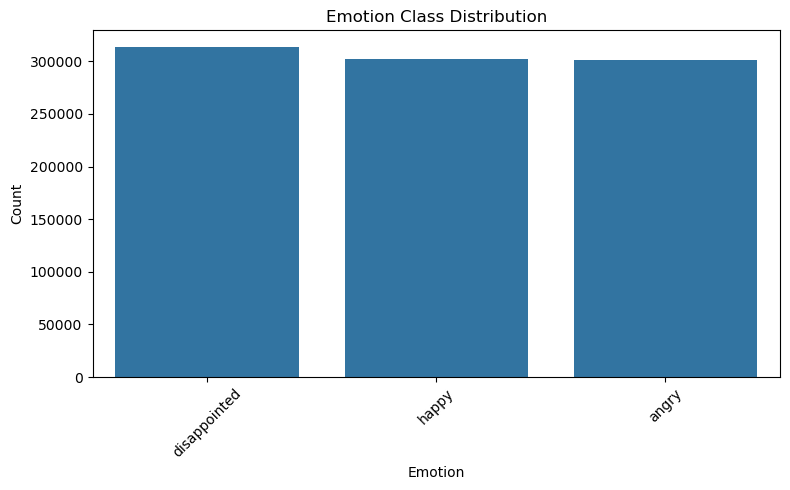

In [18]:
plt.figure(figsize=(8, 5))
sns.countplot(x='Emotion', data=df)
plt.title('Emotion Class Distribution')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [19]:
df['text_len'] = df['Content'].apply(lambda x: len(str(x).split()))
df['char_len'] = df['Content'].apply(lambda x: len(str(x)))

plt.figure(figsize=(12, 5))

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

- Word count distribution (Words per tweet)

Text(0.5, 1.0, 'Word Count Distribution')

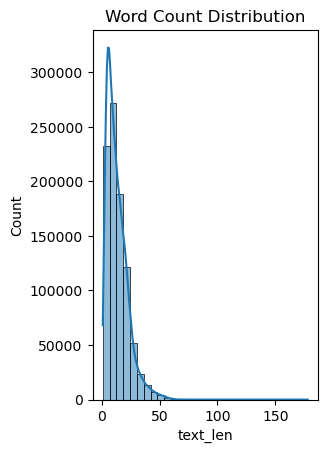

In [20]:
plt.subplot(1, 2, 1)
sns.histplot(df['text_len'], kde=True, bins=30)
plt.title('Word Count Distribution')

- Character count distribution (Characters per tweet)

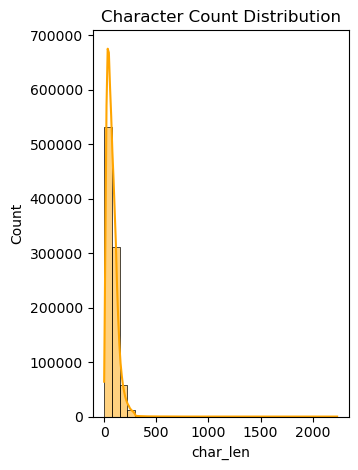

In [21]:
plt.subplot(1, 2, 2)
sns.histplot(df['char_len'], kde=True, bins=30, color='orange')
plt.title('Character Count Distribution')

plt.tight_layout()
plt.show()

- Word Cloud foe each emotion

In [22]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sampras/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [23]:
def clean_text(text):
    text = str(text).lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = " ".join([word for word in text.split() if word not in stop_words])
    return text

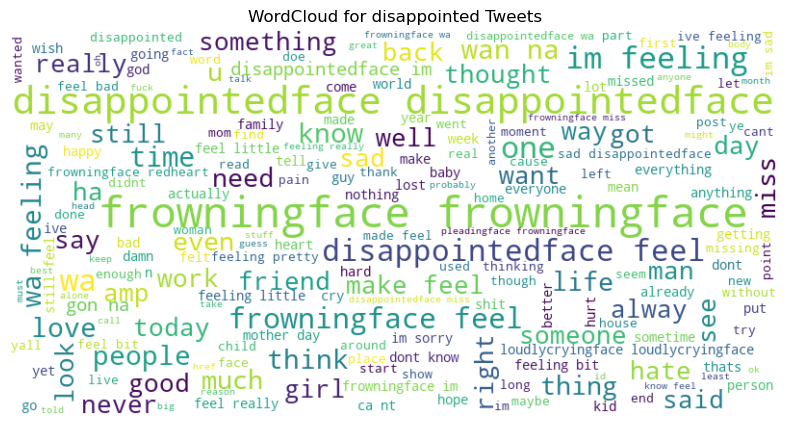

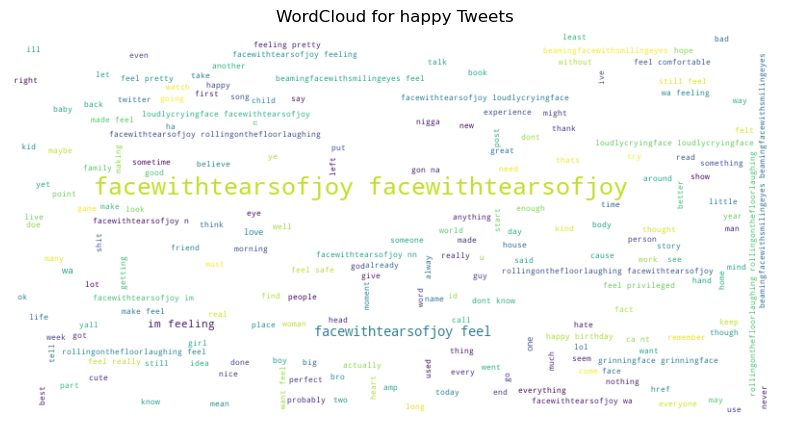

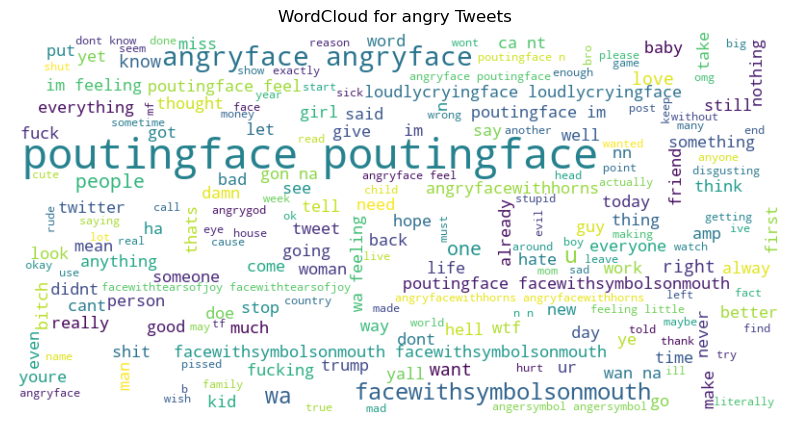

In [24]:
df['cleaned'] = df['Content'].apply(clean_text)

for emotion in df['Emotion'].unique():
    text = " ".join(df[df['Emotion'] == emotion]['cleaned'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'WordCloud for {emotion} Tweets')
    plt.show()

- Top Words Per Emotion

In [25]:
def get_top_words(emotion, n=10):
    text = " ".join(df[df['Emotion'] == emotion]['cleaned'])
    words = text.split()
    return dict(Counter(words).most_common(n))

In [27]:
top_words = {emotion: get_top_words(emotion) for emotion in df['Emotion'].unique()}

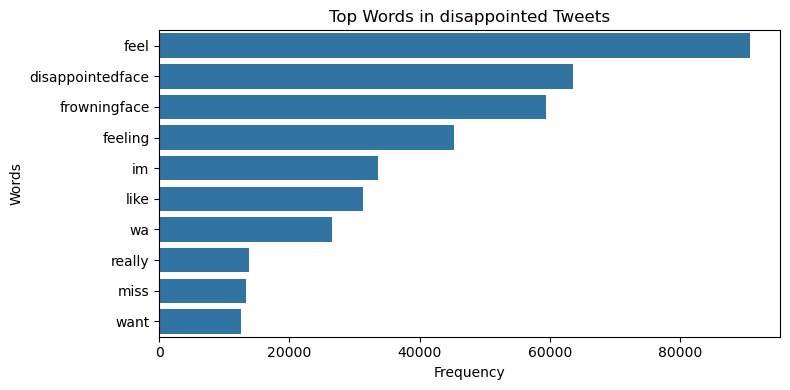

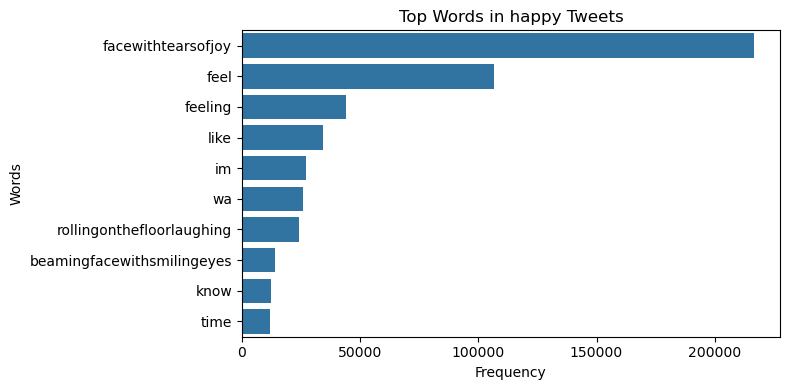

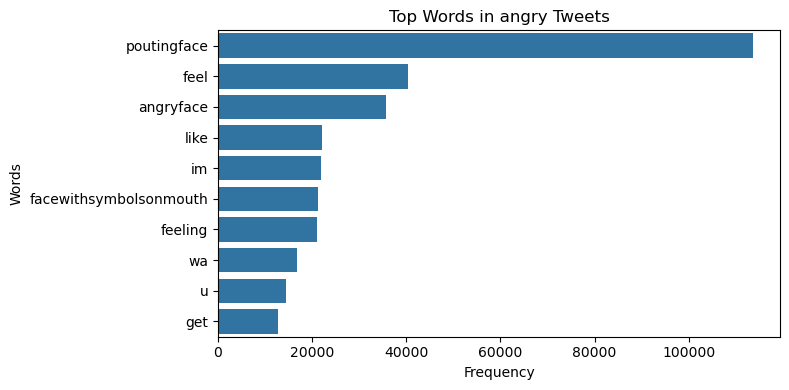

In [28]:
for emotion, word_freq in top_words.items():
    words = list(word_freq.keys())
    freqs = list(word_freq.values())
    plt.figure(figsize=(8, 4))
    sns.barplot(x=freqs, y=words)
    plt.title(f'Top Words in {emotion} Tweets')
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.tight_layout()
    plt.show()

- Word and Character Length per Emotion

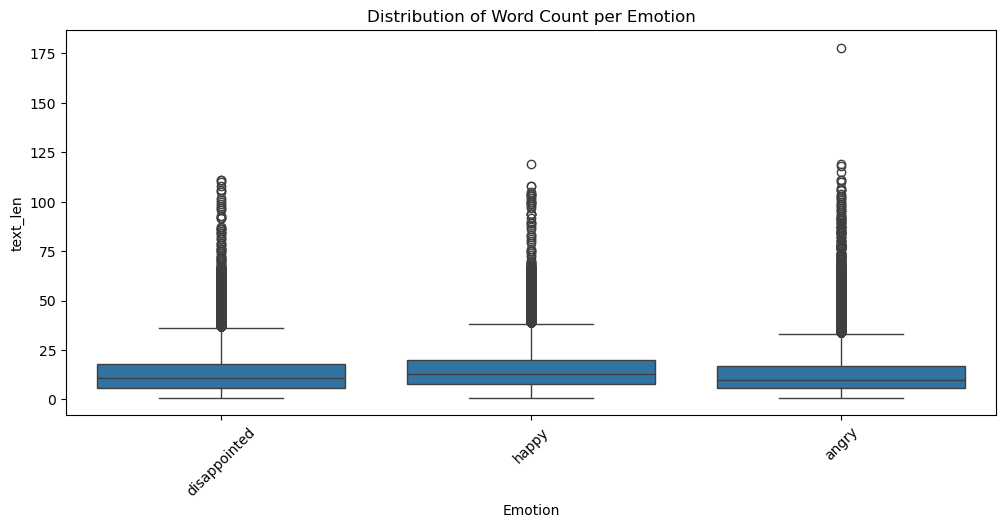

In [29]:
plt.figure(figsize=(12, 5))
sns.boxplot(x='Emotion', y='text_len', data=df)
plt.title('Distribution of Word Count per Emotion')
plt.xticks(rotation=45)
plt.show()

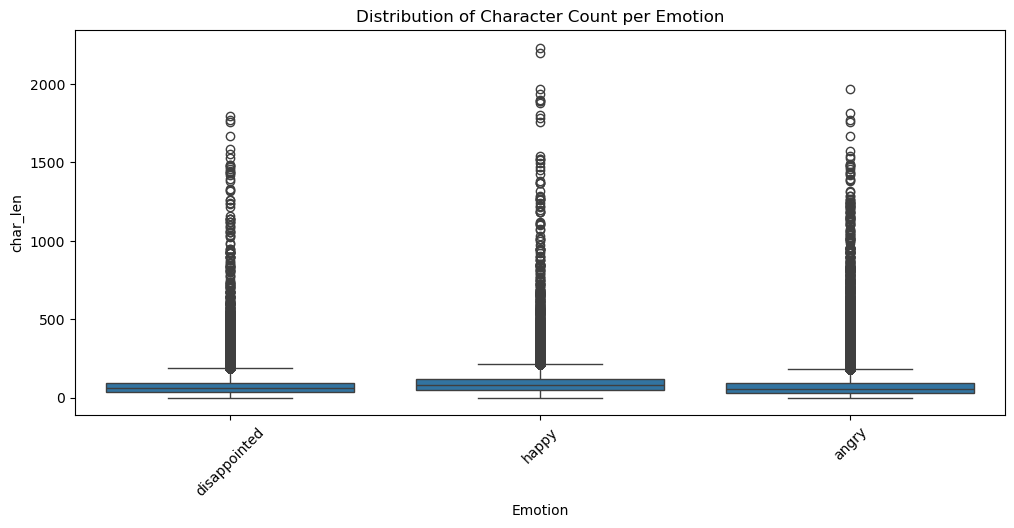

In [30]:
plt.figure(figsize=(12, 5))
sns.boxplot(x='Emotion', y='char_len', data=df)
plt.title('Distribution of Character Count per Emotion')
plt.xticks(rotation=45)
plt.show()

- Find Duplicates

In [34]:
print("Duplicate Tweets:", df.duplicated('Content').sum())

Duplicate Tweets: 68088


- Sentiment Score Distribution (TextBlob / VADER)

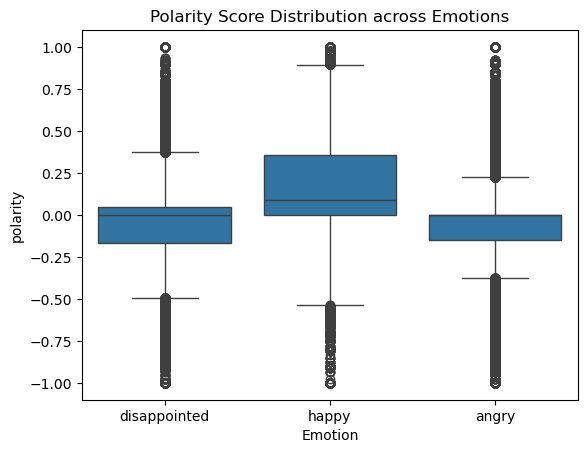

In [37]:
df['polarity'] = df['Content'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
sns.boxplot(data=df, x='Emotion', y='polarity')
plt.title('Polarity Score Distribution across Emotions')
plt.show()

- POS Tag Distribution (Per Emotion)

In [38]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /Users/sampras/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/sampras/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [39]:
def pos_tags(text):
    tokens = nltk.word_tokenize(text)
    tags = nltk.pos_tag(tokens)
    return [tag for word, tag in tags]

In [40]:
df['pos_tags'] = df['cleaned'].apply(pos_tags)

In [47]:
tfidf = TfidfVectorizer(stop_words='english', max_features=1000)
X = tfidf.fit_transform(df['cleaned'])
features = pd.DataFrame(X.toarray(), columns=tfidf.get_feature_names_out())
features['Emotion'] = df['Emotion']

- Bigram / Trigram Frequency

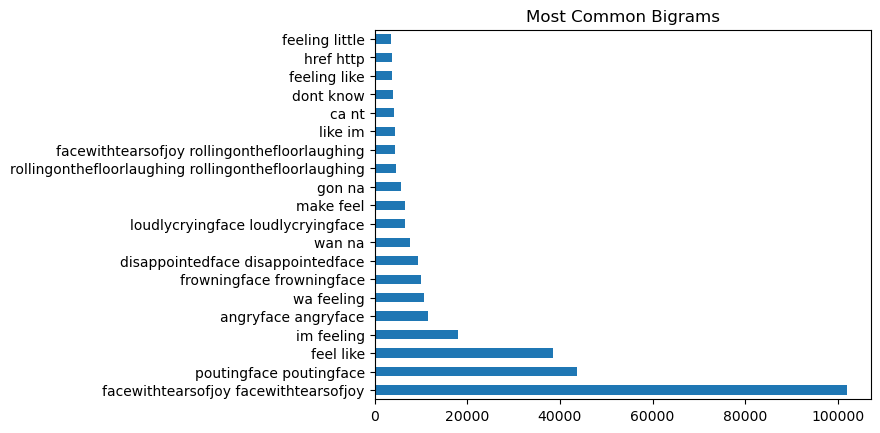

In [49]:
bigram_vec = CountVectorizer(ngram_range=(2,2), stop_words='english', max_features=20)
X2 = bigram_vec.fit_transform(df['cleaned'])
bigrams = pd.DataFrame(X2.toarray(), columns=bigram_vec.get_feature_names_out())
bigrams.sum().sort_values(ascending=False).plot(kind='barh')
plt.title("Most Common Bigrams")
plt.show()

- Topic Modeling (check latent themes in dataset)